# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [31]:
import warnings
warnings.simplefilter("ignore")

# Необходимый набор библиотек
!pip install matplotlib==3.7.3 numpy==1.22 seaborn==0.11.1 -q
!pip install --upgrade scikit-learn -q
!pip install shap -q
!pip install phik -q
!pip install python-levenshtein -q

# Работа с данными
import pandas as pd
import numpy as np

# Визуализация, построение графиков
from matplotlib import pyplot as plt
import seaborn as sns

# Применение регулярных выражений
import re

# Разбиение данных на тренировочную выборку и тестовую
from sklearn.model_selection import train_test_split

# Создание pipeline
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from time import time
import math
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor

# Проверка уникальности значений в object
from fuzzywuzzy import fuzz

# Настройка вывода всех столбцов для метода display
pd.set_option('display.max_columns', None)

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

## Подготовка данных

Загрузка данных

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Узнаем самую позднюю дату выгрузки данных, чтобы исключить информацию за пределами этой даты.

In [4]:
df_sorted = df.sort_values('DateCrawled', ascending=False)
df_sorted['DateCrawled'].head(10)

90713     2016-04-07 14:36:58
339649    2016-04-07 14:36:56
301030    2016-04-07 14:36:55
53739     2016-04-07 14:36:54
204218    2016-04-07 14:36:53
304465    2016-04-07 14:36:46
218564    2016-04-07 14:36:45
36475     2016-04-07 14:36:45
124250    2016-04-07 14:36:44
222289    2016-04-07 14:36:44
Name: DateCrawled, dtype: object

Сразу удалим столбцы, которы никак не вkияют на предсказание стоимости машины, а именно:
- LastSeen
- PostalCode
- NumberOfPictures
- DateCreated
- DateCrawled
- RegistrationMonth

Разберем почему мы удаляем эти признаки :
1. Признаки, которые относятся к пользователю, а не к автомобилю:
- LastSeen — дата последней активности пользователя
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- DateCreated — дата создания анкеты
- DateCrawled — дата скачивания анкеты из базы

Все эти признаки, никак не влияют на характеристики автомобиля и не влияют на стоимость автомобиля

- NumberOfPictures

У нас одно значение по этому полю - 0, удаляем

- RegistrationMonth — месяц регистрации автомобиля

При определении стоимости автомобиля обычно учитывается только год регистрации, а месяц игнорируется

In [5]:
df = df.drop(columns = ['LastSeen', 'PostalCode', 'DateCreated', 'DateCrawled', 'RegistrationMonth', 'NumberOfPictures'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [6]:
display(df.head(10))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


Осталось понять что делать с пропусками.
<br>Удаление пропусков - слишком дорогостоящая операция, так как мы теряем очень много данных. При этом в случае удаления мы теряем часть бизнес-сценариев, так как ситуации, когда клиент не указывает какие-то параметры автомобиля - нередкость, и в идеале модель должна уметь обрабатывать и их.

При работе с категориальными признаками стоит использовать заглушки в виде новых значений категорий для заполнения пропусков: это позволит как сохранить наблюдения вместо их удаления, так и избавит нас от возможных ошибок при эмпирическом импутировании.

В данном случае заменим пропущенные данные значением 'unknown'

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [8]:
df = df.fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Проверка данных кастомными функциями

In [9]:
# Создадим функцию отоброжения первичной информации о датасете (выборке)
def data_head_desc_info(data):
    try:
        # сразу преобразуем наименование столбцов в нижний регистр и стиль snake_case
        data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() for i in data.columns]
        print('---------------------------------------------------------------------------------------------------------------')
        print('Первые 3 строки:')
        print('---------------------------------------------------------------------------------------------------------------')
        display(data.head(3))
        print('---------------------------------------------------------------------------------------------------------------')
        print('Описание данных:')
        print('---------------------------------------------------------------------------------------------------------------')
        display(data.describe(include="all", datetime_is_numeric=True))
        print('---------------------------------------------------------------------------------------------------------------')
        print('Общая информация о датафрейме')
        print('---------------------------------------------------------------------------------------------------------------')
        display(data.info())
        print('---------------------------------------------------------------------------------------------------------------')
        print('Исследование пропусков')
        print('---------------------------------------------------------------------------------------------------------------')
        frame = {
                'nan_кол-во': data.isna().sum().sort_values(ascending=False),
                'nan_%': round((data.isna().mean() * 100), 1).sort_values(ascending=False),
            }
        nan_data = pd.DataFrame(frame)
        nan_data = nan_data.style.format({'nan_%': '{:.1f}%'})
        nan_data = nan_data.background_gradient(axis=0, cmap='YlOrRd')
        display(nan_data)
        print('---------------------------------------------------------------------------------------------------------------')
        print('Доля явных дубликатов')
        print('---------------------------------------------------------------------------------------------------------------')
        print(f"{data.duplicated().sum() / data.shape[0] * 100:.2f}%")
    except:
        return 'Проверьте параметры'

In [10]:
data_head_desc_info(df)

---------------------------------------------------------------------------------------------------------------
Первые 3 строки:
---------------------------------------------------------------------------------------------------------------


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown


---------------------------------------------------------------------------------------------------------------
Описание данных:
---------------------------------------------------------------------------------------------------------------


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
count,354369.000000,354369,354369.000000,354369,354369.000000,354369,354369.000000,354369,354369,354369
unique,NaN,9,NaN,3,NaN,251,NaN,8,40,3
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,91457,NaN,268251,NaN,29232,NaN,216352,77013,247161
mean,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,NaN,NaN,NaN
std,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,NaN,NaN,NaN
75%,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,NaN,NaN,NaN


---------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме
---------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       354369 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            354369 non-null  object
 4   power              354369 non-null  int64 
 5   model              354369 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          354369 non-null  object
 8   brand              354369 non-null  object
 9   repaired           354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


None

---------------------------------------------------------------------------------------------------------------
Исследование пропусков
---------------------------------------------------------------------------------------------------------------


,nan_кол-во,nan_%
price,0,0.0%
vehicle_type,0,0.0%
registration_year,0,0.0%
gearbox,0,0.0%
power,0,0.0%
model,0,0.0%
kilometer,0,0.0%
fuel_type,0,0.0%
brand,0,0.0%
repaired,0,0.0%


---------------------------------------------------------------------------------------------------------------
Доля явных дубликатов
---------------------------------------------------------------------------------------------------------------
12.71%


In [11]:
print(df.duplicated().sum())

45040


Дубликаты, которые образовались после удаления части признаков, нужно удалять непосредственно перед машинным обучением: с точки зрения EDA такие дубликаты - разные автомобили, у которых после удаления разных характеристик остались только те, которые пересекаются. Поэтому такие дубликаты должны быть учтены в EDA, так как они описывают особенности распределения данных.
    
На данном этапе стоит проверить дубликаты до удаления лишних признаков, а уже перед машинным обучением удалить те, которые появились после удаления лишних признаков.

In [12]:
# Функция проверки неявных дубликатов в столбцах типа object
def check_unique_object_columns(df):
    print('------------------------------------------------------------------------------------------------------------------')
    print('Проверка неявных дубликатов в столбцах типа object:')
    print('------------------------------------------------------------------------------------------------------------------')
    if not isinstance(df, pd.DataFrame):
        print("Вход должен быть DataFrame pandas.")
        return None

    object_cols = df.select_dtypes(include=['object']).columns
    if object_cols.empty:
        print("В DataFrame нет столбцов типа object.")
        return None

    results = {}
    for col in object_cols:
        unique_vals = df[col].unique()
        results[col] = {
            'число_уникальных_значений': len(unique_vals),
            # Преобразование в список для лучшего отображения
            'уникальных_значения': unique_vals.tolist(),
            'потенциальные_дубликаты': []
        }

        # Базовая проверка потенциальных дубликатов:
        # Проверяет значения с разными регистрами или незначительными вариациями.
        for i, val in enumerate(unique_vals):
            if unique_vals.tolist().count(val) > 1 and val != '':  # важная проверка на пустую строку!
                for j, other_val in enumerate(unique_vals):
                    if i != j and fuzz.ratio(val.lower(), other_val.lower()) >= 90:
                        #  Уникальная строка не должна быть в списке дубликатов
                        if other_val not in results[col]['потенциальные_дубликаты']: 
                            results[col]['потенциальные_дубликаты'].append(other_val)

    result_df = pd.DataFrame.from_dict(results, orient='index')
    display(result_df)
    
    print('------------------------------------------------------------------------------------------------------------------')
    print('Вывод всех уникальных значений:')
    print('------------------------------------------------------------------------------------------------------------------')
    
    # Вывод всех уникальных значений
    for col in object_cols:
        print(f"\nСтолбец {col}:")
        print(f"Уникальные значения: {result_df.loc[col, 'уникальных_значения']}")

In [13]:
check_unique_object_columns(df)

------------------------------------------------------------------------------------------------------------------
Проверка неявных дубликатов в столбцах типа object:
------------------------------------------------------------------------------------------------------------------


,число_уникальных_значений,уникальных_значения,потенциальные_дубликаты
vehicle_type,9,"[unknown, coupe, suv, small, sedan, convertibl...",[]
gearbox,3,"[manual, auto, unknown]",[]
model,251,"[golf, unknown, grand, fabia, 3er, 2_reihe, ot...",[]
fuel_type,8,"[petrol, gasoline, unknown, lpg, other, hybrid...",[]
brand,40,"[volkswagen, audi, jeep, skoda, bmw, peugeot, ...",[]
repaired,3,"[unknown, yes, no]",[]


------------------------------------------------------------------------------------------------------------------
Вывод всех уникальных значений:
------------------------------------------------------------------------------------------------------------------

Столбец vehicle_type:
Уникальные значения: ['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other']

Столбец gearbox:
Уникальные значения: ['manual', 'auto', 'unknown']

Столбец model:
Уникальные значения: ['golf', 'unknown', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max', '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse', 'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo', 'focus', 'tt', 'a6', 'jazz', '

FuelType - значения petrol и gasoline по сути означают одно и то же, можно привести к одной форме.

Model - значения rangerover и range_rover аналогично характеризуют одну модель, можно также привести к одной форме.

In [14]:
df = df.replace({'gasoline':'petrol', 'rangerover':'range_rover'})

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       354369 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            354369 non-null  object
 4   power              354369 non-null  int64 
 5   model              354369 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          354369 non-null  object
 8   brand              354369 non-null  object
 9   repaired           354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


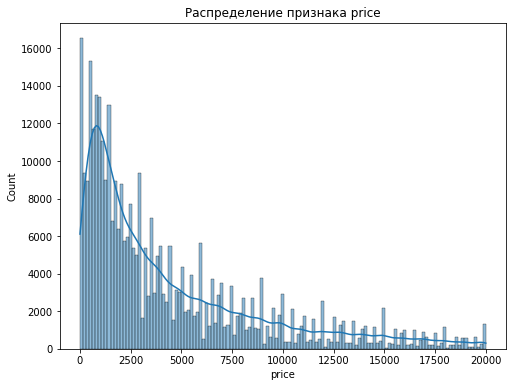

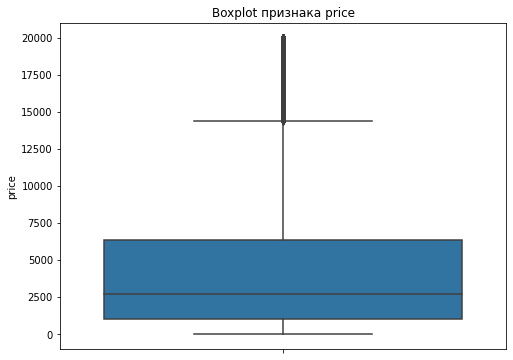

Описание признака price:
count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64



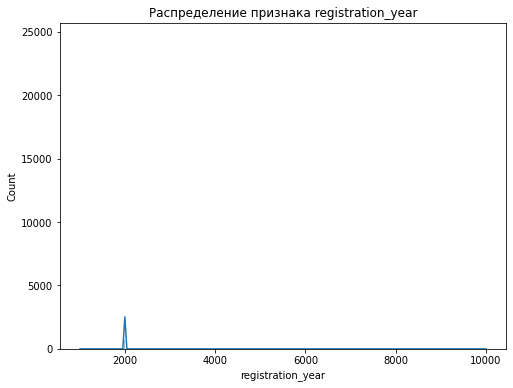

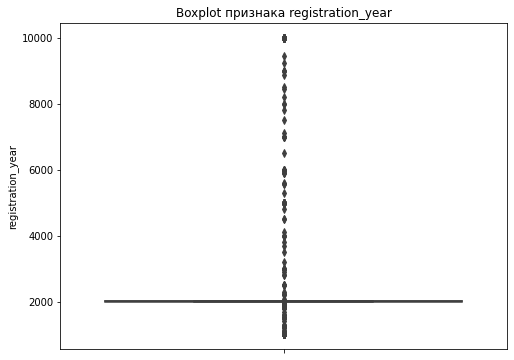

Описание признака registration_year:
count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64



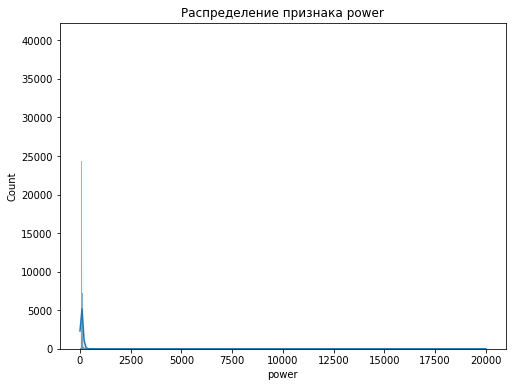

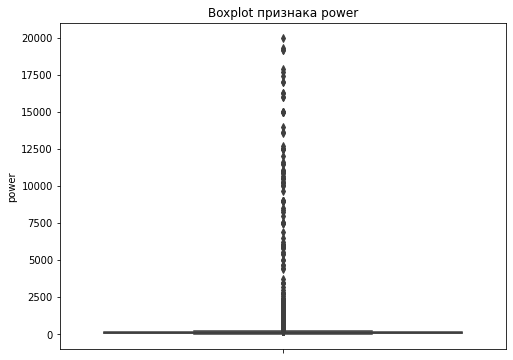

Описание признака power:
count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64



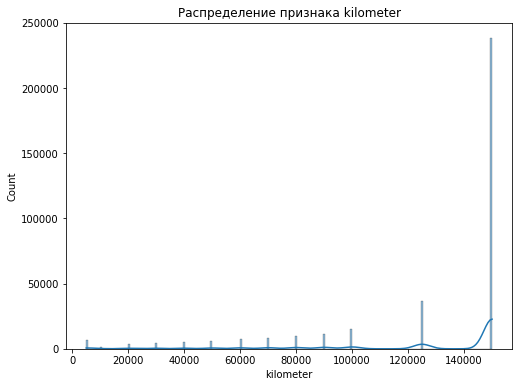

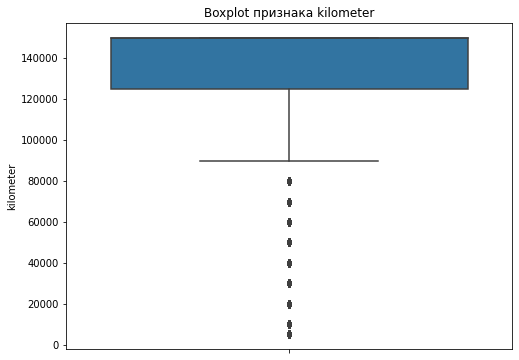

Описание признака kilometer:
count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64



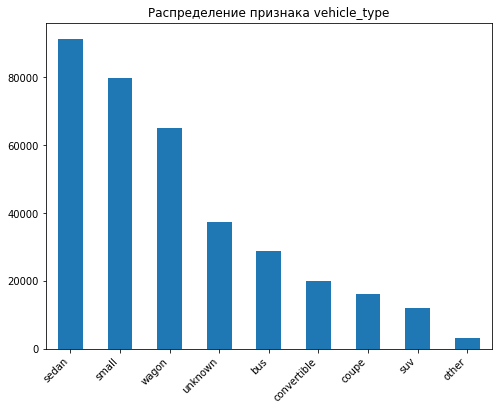

Уникальные значения для vehicle_type:
 ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']



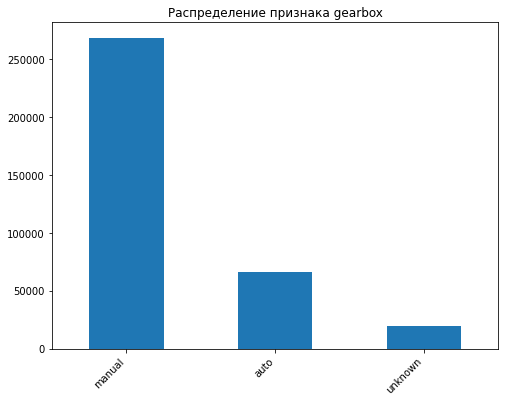

Уникальные значения для gearbox:
 ['manual' 'auto' 'unknown']



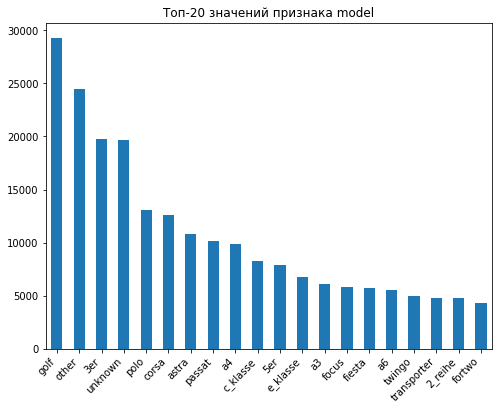

Уникальные значения для model:
 ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl

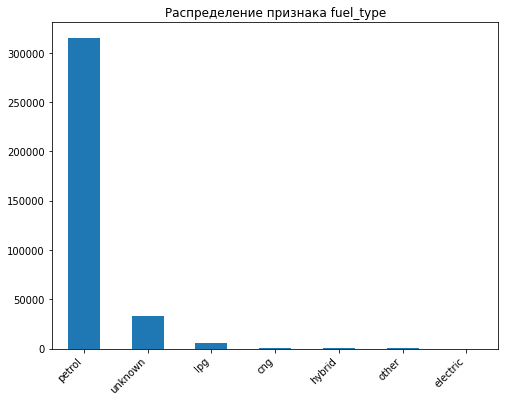

Уникальные значения для fuel_type:
 ['petrol' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']



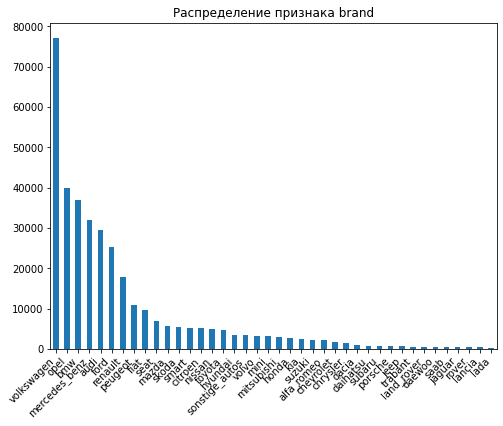

Уникальные значения для brand:
 ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']



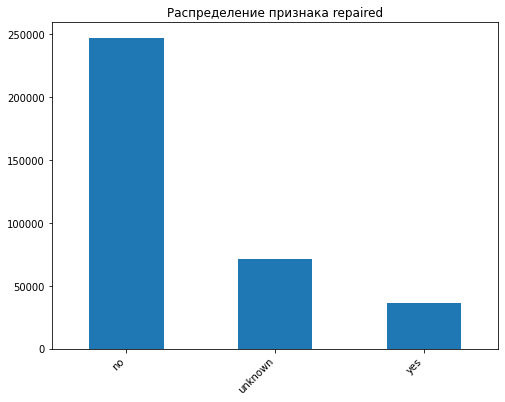

Уникальные значения для repaired:
 ['unknown' 'yes' 'no']



In [16]:
# Разделяем числовые и категориальные столбцы
numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include=object).columns


for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f"Распределение признака {col}")
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot признака {col}")
    plt.show()

    print(f"Описание признака {col}:\n{df[col].describe()}\n")


for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    if col == 'model':  
        top_n = 20
        df[col].value_counts().nlargest(top_n).plot(kind='bar')
        plt.title(f"Топ-{top_n} значений признака {col}")
    else:  
        df[col].value_counts().plot(kind='bar')
        plt.title(f"Распределение признака {col}")
    plt.xticks(rotation=45, ha="right")
    plt.show()
    print(f"Уникальные значения для {col}:\n {df[col].unique()}\n")

In [17]:
print((df['power'] > 900).sum())
print((df['power'] == 0).sum())

329
40225


Промежуточный итог:
Поля в котрых есть явные некорректные данные.
1. power - максимальное значение 20000. Путем пребора вариантов на auto.ru, было выяснено, что машины продаются с мощностью до 900 л.с. Возьмем 900 как крайнее значение. Нулевые значения, их много. Можно поробовать их заменить на медианное значение. Но значений много и медианное значение в таком количестве будет искажать данные и модель обучаться неправильно. Поэтому я удалю нулевые значения. Также удалим околонулевые значения, остаим автомобили у которых мощность выше 30 л.с. 

In [18]:
print((df['power'] > 900).sum())
print((df['power'] == 0).sum())

df = df[df['power'] <= 900]
df = df[df['power'] >= 30]

print((df['power'] > 900).sum())
print((df['power'] < 30).sum())

329
40225
0
0


2. registration_year - максимлаьное значение 9999, чего быть не может. Возьмем за верхнюю отметку год загрузки данных 2016, отсутствие данных по машинам страше 2016 года не должны повлиять на обучение моделей. 2016 год - верхнее значение. Нижнее значение оставим 1930, предрположим что у нас есть ретро автомобили.

In [19]:
(df['registration_year'] > 2016).sum()

10761

In [20]:
(df['registration_year'] < 1930).sum()

17

In [21]:
df = df[df['registration_year'] <= 2016]
df = df[df['registration_year'] >= 1930]
print((df['registration_year'] > 2016).sum())
print((df['registration_year'] < 1930).sum())

0
0


3. price - целевой признак. Очень много значений со стоимостью 0. Удаляем эти значения. Удалить неадекватно низкие значения цен: в пределах цен до 500-1000 евро вряд ли можно купить полноценный автомобиль

In [22]:
(df['price'] < 500).sum()

23371

In [23]:
df = df[df['price'] >= 500]
(df['price'] == 0).sum()

0

Теперь снова проверим на нашу выборку на дубликаты

In [24]:
df.duplicated().sum()

38287

In [25]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278758 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              278758 non-null  int64 
 1   vehicle_type       278758 non-null  object
 2   registration_year  278758 non-null  int64 
 3   gearbox            278758 non-null  object
 4   power              278758 non-null  int64 
 5   model              278758 non-null  object
 6   kilometer          278758 non-null  int64 
 7   fuel_type          278758 non-null  object
 8   brand              278758 non-null  object
 9   repaired           278758 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.4+ MB


## Обучение моделей

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278758 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              278758 non-null  int64 
 1   vehicle_type       278758 non-null  object
 2   registration_year  278758 non-null  int64 
 3   gearbox            278758 non-null  object
 4   power              278758 non-null  int64 
 5   model              278758 non-null  object
 6   kilometer          278758 non-null  int64 
 7   fuel_type          278758 non-null  object
 8   brand              278758 non-null  object
 9   repaired           278758 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.4+ MB


In [27]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
def create_pipeline(model):
    # Определяем название категориальных и числовых признаков
    numerical_features = ['registration_year', 'power', 'kilometer']
    categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

    #Создаем пайплайн для предварительной обработке признаков
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        (('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)))
    ])

    # Масштабирование количественных признаков 
    # (вобще масштабирование не обязаттельно для градиентного бустинга, тк.к это дерево решений и оно не чувствительно к масштабу)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    #Создаем пайплайн подготовки и обучение модели
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipeline

In [32]:
%%time
models = {
    'CatBoost': CatBoostRegressor(loss_function='RMSE', random_seed=42, verbose=0),
    'LightGBM': lgb.LGBMRegressor(objective='regression', random_state=42, metric='rmse', verbose=-1),
    'RandomForest': RandomForestRegressor(random_state=42)
}


param_grids = {
    'CatBoost': {'model__iterations': [50, 100], 'model__learning_rate': [0.1, 0.01], 'model__depth': [6]}, 
    'LightGBM': {'model__num_leaves': [64], 'model__learning_rate': [0.1], 'model__n_estimators': [100]}, 
    'RandomForest': {'model__n_estimators': [100], 'model__max_depth': [6]}
}


results = []
for model_name, model in models.items():
    pipeline = create_pipeline(model)
    # параметры grid search
    grid_search = GridSearchCV(pipeline, 
                               param_grids[model_name], 
                               scoring='neg_mean_squared_error', 
                               cv=3, 
                               n_jobs=-1)

    # Находим лучшие гиперпараметры для модели из цикла
    grid_search.fit(X_train, y_train)

    # лучшая модель для алгоритма из цикла
    best_model = grid_search.best_estimator_
    # метрика промежуточной оценки модели — это метрика RMSE с кросс-валидации
    # т.к. внутри grid search была проведена кросс-валидация
    rmse_cv_train = math.sqrt(-grid_search.best_score_)

    # теперь обучаем модель с лучшими парметрами на train и замеряем время
    start_time_training = time()
    best_model.fit(X_train, y_train)
    end_time_training = time()
    training_time = (end_time_training - start_time_training) / 60

    # предсказание на train и замеряем время
    start_time_prediction = time()
    y_pred_train = best_model.predict(X_train)
    end_time_prediction = time()
    prediction_time_train = (end_time_prediction - start_time_prediction) / 60
    
    results.append({
        'model': model_name,
        'rmse_cv_train': rmse_cv_train,
        'training_time': training_time,
        'prediction_time_train': prediction_time_train,
        'best_params': grid_search.best_params_
    })

results_df = pd.DataFrame(results)
print(results_df)

          model  rmse_cv_train  training_time  prediction_time_train  \
0      CatBoost    1809.307027       0.072953               0.011017   
1      LightGBM    1632.674862       0.101682               0.040090   
2  RandomForest    2231.285883       0.309310               0.022314   

                                         best_params  
0  {'model__depth': 6, 'model__iterations': 100, ...  
1  {'model__learning_rate': 0.1, 'model__n_estima...  
2  {'model__max_depth': 6, 'model__n_estimators':...  
CPU times: user 2min 23s, sys: 341 ms, total: 2min 23s
Wall time: 2min 31s


## Анализ моделей

In [33]:
# Выбор лучшей модели на основе RMSE из кросс-валидации
best_model_name = results_df.loc[results_df['rmse_cv_train'].idxmin(), 'model'] #выбираем лучшую модель
print(f"\nЛучшая модель по RMSE из кросс-валидации: {best_model_name}")


best_pipeline = create_pipeline(models[best_model_name])
best_pipeline.set_params(**results_df[results_df['model'] == best_model_name]['best_params'].iloc[0])

# Оценка лучшей модели на тестовой выборке
best_pipeline = create_pipeline(models[best_model_name])
best_pipeline.set_params(**results_df[results_df['model'] == best_model_name]['best_params'].iloc[0])
best_pipeline.fit(X_train, y_train)
y_pred_test = best_pipeline.predict(X_test)
test_rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"\nRMSE лучшей модели на тестовом наборе: {test_rmse}")


Лучшая модель по RMSE из кросс-валидации: LightGBM

RMSE лучшей модели на тестовом наборе: 1631.42866355217


**Вывод:**

Учитывая критерии заказчика (качество прогнозирования, время обучения и время прогнозирования), LightGBM обеспечивает наилучшее соотношение качества и скорости. Качество модели (RMSE) лучше чем у остальных моделей как и время обучение. Время предсказания уступает CatBoostRegressor, но у LightGBM значительно лучше качество что делает модель LightGBM наиболее подходящей.

Разница оценки качества на тренировочной выборке и на тестовой небольшое, что говорит о том что модель обучилась хорошо.


 ### Проверка адекватнсти модели сравнением с константной моделью

Очень важно также проверить лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели, которая предсказывала бы константу - вдруг окажется, что не было бы большого смысла заниматься созданием новых признаков, тюнингом и кросс-валидацией моделей, если можно было бы просто предсказывать среднее значение тренировочной выборки?

В качестве константной модели можно использовать DummyRegressor  - эта модель как раз создана для генерирования константных предсказаний.

Важно, чтобы результат тестирования нашей модели на тествой выборке был лучше, чем результат константной модели - в противном случае наша модель является бесполезной, так как все наши усилия над проектом не принесли результата, а можель, просто предсказывющая среднее на train, делает нашу работу лучше.

In [34]:
# Регрессор, который делает прогнозы, используя простые правила.
# Этот регрессор полезен в качестве простого базового варианта для сравнения с другими (реальными) регрессорами. 
# Не используется для решения реальных задач.

dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)
dummy_rmse = math.sqrt(mean_squared_error(y_test, y_pred_dummy))
print(f"RMSE DummyRegressor на тестовом наборе: {dummy_rmse}")

# Сравнение результатов
if test_rmse < dummy_rmse:
    print("Выбранная модель работает лучше, чем константная.")
else:
    print("Вывод: Константная модель работает лучше чем выбранная. Необходим пересмотр выбранной модели.")

RMSE DummyRegressor на тестовом наборе: 4612.775175440534
Выбранная модель работает лучше, чем константная.
